In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from RATIO_LVAE_shGLM import RATIO_LVAE_shGLM
from sklearn import metrics
import torch.distributions as dist

In [2]:
dends = np.fromfile("/media/hdd01/sklee/cont_shglm/inputs/ALLOFF_vDdata_NMDA_ApN0.5_13_passive_r0_o2_i2_g_b0.bin")[1:]
volt = np.fromfile("/media/hdd01/sklee/cont_shglm/inputs/ALLOFF_vdata_NMDA_ApN0.5_13_passive_r0_o2_i2_g_b0.bin")[1:-1]

#dends = np.fromfile("/media/hdd01/sklee/cont_shglm/inputs/NA_vDdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")[1:]
#volt = np.fromfile("/media/hdd01/sklee/cont_shglm/inputs/NA_vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")[1:-1]

In [3]:
print(dends.shape)

(38404,)


In [4]:
print(dends.shape)
new_dends = np.empty((9601,4))
for i in range(dends.shape[0]):
    new_dends[i//4, i%4] = dends[i]
    #new_dends[i%48001, i//48001] = dends[i]
    
    

(38404,)


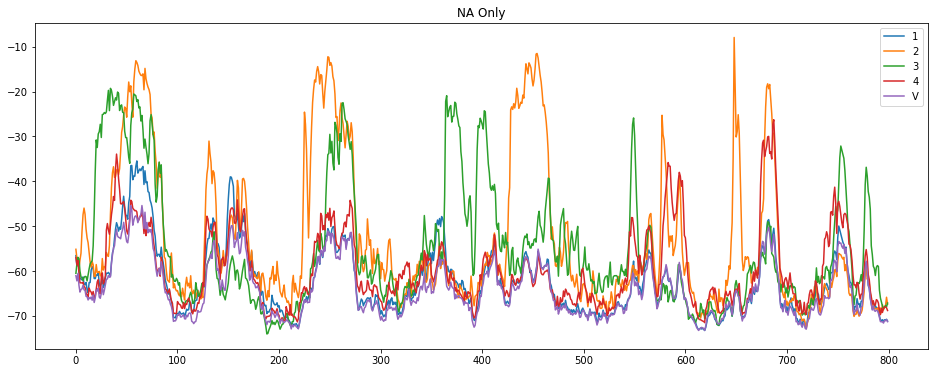

In [13]:
plt.figure(figsize = (16,6))
plt.title("NA Only")
plt.plot(new_dends[4000:4800,0], label="1")
plt.plot(new_dends[4000:4800,1], label="2")
plt.plot(new_dends[4000:4800,2], label="3")
plt.plot(new_dends[4000:4800,3], label="4")
plt.plot(volt[4000:4800], label="V")
plt.legend()

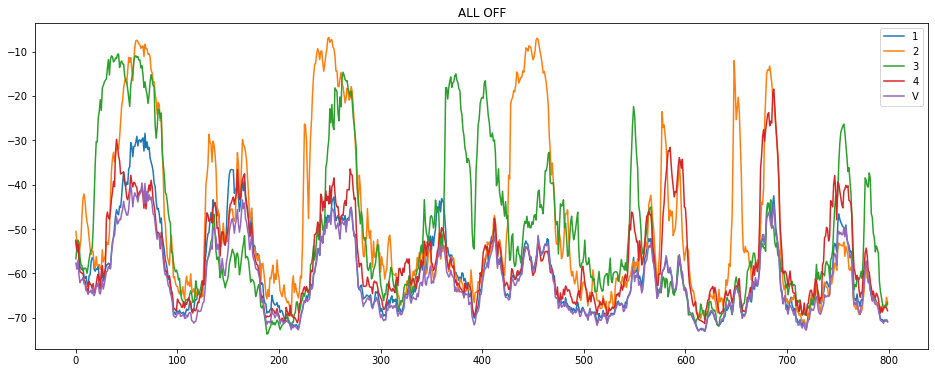

In [5]:
plt.figure(figsize = (16,6))
plt.title("ALL OFF")
plt.plot(new_dends[4000:4800,0], label="1")
plt.plot(new_dends[4000:4800,1], label="2")
plt.plot(new_dends[4000:4800,2], label="3")
plt.plot(new_dends[4000:4800,3], label="4")
plt.plot(volt[4000:4800], label="V")
plt.legend()

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000

C_den = torch.zeros(5,5)
C_den[0,1:] = 1
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 2
hist_basis_no = 2
T_hist = 201
T_syn = 201
T_enc = 201
hid_dim = 256
temp = 0.5

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = RATIO_LVAE_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), E_no, T_syn, syn_basis_no,
                T_hist, hist_basis_no, T_enc, hid_dim, temp)
model = model.float().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/cont_shglm/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37000
37000


In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
loss_array = np.empty((batch_no))
beta = 0

for i in tnrange(batch_no):
    
    if i%250 == 249 and i <= 2500:
        beta += 0.1
    
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()
    
    batch_pred, rec_loss, KL_loss, Z_P_prior, Z_P_post = model(batch_ref,
                                                              batch_S_E,
                                                              batch_S_I,
                                                              beta)
        
    loss = rec_loss + beta*KL_loss
    loss_array[i] = loss.item()
    
    print(i, rec_loss.item(), KL_loss.item())
    
    loss.backward()
    optimizer.step()
    
    if i%50 == 0:
        model.eval()
        test_pred, test_Y, test_spikes, test_ratios = model.decode(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/lvae_shglm/RATIO_LVAE_sub5_s2_h2_shglm_i"+str(i)+".pt")
    


<ipython-input-8-6a4b9a8f84f8>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


0 13.080774307250977 0.07410573214292526
TEST 0 13.660793546513709 0.010898105753961995 -0.0025767087936401367
[0.37711057 0.38496485 0.38144222 0.37373438]
1 3.860858201980591 0.15487301349639893
2 7.95797872543335 0.15419116616249084
3 17.728748321533203 0.15515510737895966
4 8.922311782836914 0.15541090071201324
5 1.5822651386260986 0.15503497421741486
6 1.542397379875183 0.15470047295093536
7 6.768373012542725 0.15510420501232147
8 1.7253025770187378 0.15355458855628967
9 7.235245227813721 0.1551191359758377
10 2.3062570095062256 0.1525718718767166
11 17.51582145690918 0.1541340947151184
12 3.888681411743164 0.1519540548324585
13 1.386354684829712 0.15152513980865479
14 3.1426563262939453 0.15397171676158905
15 14.427614212036133 0.15348073840141296
16 1.758073091506958 0.1534246951341629
17 7.699002265930176 0.15308398008346558
18 26.972543716430664 0.1541234403848648
19 5.074573993682861 0.15390360355377197
20 3.852228879928589 0.15306082367897034
21 12.515913009643555 0.15368796

187 2.289533853530884 0.15574179589748383
188 3.8474533557891846 0.15559887886047363
189 5.461214542388916 0.15638849139213562
190 3.7644498348236084 0.15649867057800293
191 14.672942161560059 0.15766170620918274
192 7.557098388671875 0.15751075744628906
193 1.1342229843139648 0.15510781109333038
194 1.1127538681030273 0.1550494134426117
195 10.966704368591309 0.1562081277370453
196 2.7277774810791016 0.15570273995399475
197 1.2552423477172852 0.15543514490127563
198 3.783499240875244 0.15759828686714172
199 5.460854530334473 0.15719978511333466
200 1.7025761604309082 0.15555284917354584
TEST 200 10.906047407957185 0.21035391447424967 0.2838825583457947
[0.4144487  0.41238764 0.40783963 0.40833   ]
201 3.3703465461730957 0.15771619975566864
202 19.44230842590332 0.15707474946975708
203 14.264052391052246 0.15769612789154053
204 1.7127450704574585 0.15584486722946167
205 3.2146575450897217 0.15579746663570404
206 2.6975414752960205 0.15709242224693298
207 10.627546310424805 0.1569579243

371 2.2982609272003174 0.156866654753685
372 2.567235231399536 0.15691469609737396
373 2.8606984615325928 0.15649347007274628
374 2.9404101371765137 0.1560652107000351
375 4.454392910003662 0.15821844339370728
376 8.598044395446777 0.15750527381896973
377 8.255660057067871 0.15827909111976624
378 1.983127474784851 0.1576244831085205
379 2.6195144653320312 0.15700171887874603
380 4.29862117767334 0.15782961249351501
381 0.9599435329437256 0.15625163912773132
382 1.0286822319030762 0.1568237841129303
383 2.146902084350586 0.15727683901786804
384 2.0243914127349854 0.1576061099767685
385 4.172055244445801 0.1568409651517868
386 9.579429626464844 0.15939168632030487
387 9.301431655883789 0.1593891829252243
388 2.5142555236816406 0.15697425603866577
389 1.2513585090637207 0.1568053662776947
390 2.090430736541748 0.15740926563739777
391 5.080038070678711 0.15756966173648834
392 4.26816987991333 0.15823817253112793
393 1.0151221752166748 0.15665432810783386
394 3.2125980854034424 0.1571800857

555 9.500292778015137 0.1566285341978073
556 7.916118144989014 0.15979723632335663
557 8.209643363952637 0.15945830941200256
558 7.2588958740234375 0.15701907873153687
559 7.0583109855651855 0.15678033232688904
560 1.6250054836273193 0.15499070286750793
561 0.9321218132972717 0.15587036311626434
562 1.791764497756958 0.1547250598669052
563 3.04009747505188 0.15462860465049744
564 2.323119640350342 0.15569090843200684
565 2.2218575477600098 0.15460997819900513
566 8.318824768066406 0.1551274210214615
567 10.927971839904785 0.15528777241706848
568 4.231654167175293 0.15607832372188568
569 2.3582451343536377 0.15425729751586914
570 4.3624091148376465 0.15537342429161072
571 1.0251492261886597 0.15635967254638672
572 1.5463734865188599 0.1549777388572693
573 2.3804988861083984 0.1558874100446701
574 2.378951072692871 0.1559412181377411
575 1.9802558422088623 0.15527480840682983
576 0.8755462765693665 0.15725207328796387
577 1.982471227645874 0.1544087678194046
578 9.736408233642578 0.15584

742 2.4868836402893066 0.15274110436439514
743 3.7272849082946777 0.15396122634410858
744 2.1153416633605957 0.15490251779556274
745 3.9239296913146973 0.1534648835659027
746 1.2064834833145142 0.15258894860744476
747 14.326142311096191 0.15885168313980103
748 8.103628158569336 0.15450522303581238
749 1.1810386180877686 0.15398921072483063
750 3.4256515502929688 0.15396766364574432
TEST 750 7.981935274274906 0.42207257050724567 0.6042702794075012
[0.4197359  0.40984592 0.40632644 0.39921266]
751 0.962532639503479 0.15488214790821075
752 1.2630056142807007 0.1526174247264862
753 1.639548420906067 0.15422187745571136
754 1.973803997039795 0.15459856390953064
755 0.9033343195915222 0.1549946665763855
756 1.4186214208602905 0.15431693196296692
757 7.880220890045166 0.15412916243076324
758 3.3544344902038574 0.15549425780773163
759 6.7400970458984375 0.1563802808523178
760 1.768914818763733 0.1544545292854309
761 0.8679961562156677 0.15482421219348907
762 9.537827491760254 0.153967738151550

926 5.849460124969482 0.15222521126270294
927 2.404911756515503 0.15239010751247406
928 1.354178547859192 0.15187111496925354
929 2.365755081176758 0.1524527221918106
930 1.1232513189315796 0.1507260799407959
931 4.269689559936523 0.15032681822776794
932 1.1297862529754639 0.15159784257411957
933 2.5158045291900635 0.1526474803686142
934 1.4061431884765625 0.15135221183300018
935 1.6272002458572388 0.14990711212158203
936 8.050975799560547 0.15078330039978027
937 2.970574378967285 0.15038670599460602
938 3.1051456928253174 0.15046003460884094
939 3.7519867420196533 0.15158124268054962
940 2.0445899963378906 0.153293639421463
941 0.9740284085273743 0.1504138857126236
942 1.2987524271011353 0.15143443644046783
943 1.0243003368377686 0.14996765553951263
944 0.7325495481491089 0.1533326506614685
945 6.24207067489624 0.15605193376541138
946 0.9081437587738037 0.15310099720954895
947 1.9965664148330688 0.15035246312618256
948 0.9537402987480164 0.15317201614379883
949 0.884050726890564 0.154

1108 18.208036422729492 0.14867928624153137
1109 0.919437825679779 0.1507548838853836
1110 3.173921585083008 0.14800919592380524
1111 2.130530595779419 0.14882469177246094
1112 1.2738553285598755 0.14652520418167114
1113 1.8997071981430054 0.1498011201620102
1114 4.931605339050293 0.1473073810338974
1115 1.7150083780288696 0.14961618185043335
1116 1.7121875286102295 0.14864590764045715
1117 1.6294771432876587 0.1463598757982254
1118 1.4431731700897217 0.1495513916015625
1119 1.5955568552017212 0.1477920562028885
1120 1.140459656715393 0.14630070328712463
1121 1.1654971837997437 0.14664898812770844
1122 2.002922773361206 0.14908398687839508
1123 4.307294845581055 0.14743609726428986
1124 1.197433590888977 0.15030039846897125
1125 2.6077382564544678 0.14869940280914307
1126 0.6770830750465393 0.15052081644535065
1127 0.8529229164123535 0.1469542682170868
1128 2.4032411575317383 0.14895133674144745
1129 2.907653331756592 0.14775772392749786
1130 5.519967555999756 0.15202118456363678
1131 

1290 2.336113452911377 0.14432598650455475
1291 1.7948628664016724 0.146109476685524
1292 4.162964344024658 0.14370344579219818
1293 5.8343400955200195 0.14332802593708038
1294 0.6100308299064636 0.14959104359149933
1295 1.2460336685180664 0.14540256559848785
1296 1.0547020435333252 0.14429642260074615
1297 1.2117398977279663 0.14997991919517517
1298 1.9925040006637573 0.14712077379226685
1299 2.1207754611968994 0.14711710810661316
1300 2.3653781414031982 0.14735940098762512
TEST 1300 5.510640599489701 0.6010052391215672 0.5152348279953003
[0.4169611  0.40502188 0.42157593 0.35225967]
1301 1.13838529586792 0.14583030343055725
1302 1.7265770435333252 0.14556321501731873
1303 1.9704701900482178 0.14750291407108307
1304 1.435639500617981 0.14866240322589874
1305 2.076115608215332 0.1470618098974228
1306 0.9286089539527893 0.1448487490415573
1307 1.1853468418121338 0.1458711326122284
1308 0.753753662109375 0.14720861613750458
1309 0.7112635374069214 0.14739415049552917
1310 1.1919523477554

1469 0.8575608730316162 0.14789558947086334
1470 1.9963481426239014 0.1440717726945877
1471 1.5256317853927612 0.14272165298461914
1472 0.7189623117446899 0.14567244052886963
1473 1.0500543117523193 0.14338256418704987
1474 0.88636314868927 0.1406605839729309
1475 4.798137187957764 0.1405610889196396
1476 1.648413896560669 0.1446782648563385
1477 0.9247392416000366 0.14058968424797058
1478 0.6215494871139526 0.14536051452159882
1479 0.9129542708396912 0.14041943848133087
1480 2.7662513256073 0.14194555580615997
1481 1.6750216484069824 0.14126451313495636
1482 2.0044023990631104 0.14349335432052612
1483 4.119370460510254 0.14197996258735657
1484 1.070111870765686 0.1426764875650406
1485 2.3791537284851074 0.139398992061615
1486 2.2493443489074707 0.13957586884498596
1487 3.9161674976348877 0.14229825139045715
1488 1.6430046558380127 0.1437796950340271
1489 2.0210423469543457 0.1444399654865265
1490 1.179510474205017 0.14326328039169312
1491 4.215444564819336 0.14025357365608215
1492 1.1

TEST 1650 4.224694317217438 0.694113439690677 0.7684771418571472
[0.40734372 0.39220142 0.43352762 0.32892096]
1651 1.4842411279678345 0.14027197659015656
1652 0.8148500919342041 0.1391901671886444
1653 0.5657448172569275 0.1457342654466629
1654 0.7675370573997498 0.14584794640541077
1655 1.5800867080688477 0.1389179527759552
1656 5.979998588562012 0.13828600943088531
1657 0.8303776383399963 0.13902337849140167
1658 0.7035149931907654 0.14415057003498077
1659 1.1350995302200317 0.1407662332057953
1660 1.0651681423187256 0.14196375012397766
1661 2.0156877040863037 0.13926909863948822
1662 3.3176159858703613 0.13901104032993317
1663 1.2540030479431152 0.13875322043895721
1664 0.8436203002929688 0.13924355804920197
1665 4.316995620727539 0.13795962929725647
1666 0.785844624042511 0.13869968056678772
1667 1.689264178276062 0.14244376122951508
1668 6.066636085510254 0.13769015669822693
1669 1.7645314931869507 0.1410757601261139
1670 1.5291202068328857 0.14088934659957886
1671 1.738723397254

1830 1.7396548986434937 0.13668550550937653
1831 1.080330729484558 0.13846474885940552



In [ ]:
plt.plot(test_pred.cpu().detach().numpy())

In [ ]:
plt.plot(test_pred.cpu().detach().numpy())